In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from scipy.integrate import quad

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  
import sys
sys.path.append("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\optimisation_experiments")
from optimise_GDD_fctns import *
from nn_response_fctns import *

In [2]:
skip = 1
numsteps = int(163 // skip)
#ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_full.csv')
#ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')

#ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

#NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype(int).values).unsqueeze(1)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

27153
27153


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_21776\356867199.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_34s6o8i12c\croot\libtorch_1751464457133\work\torch\csrc\utils\tensor_new.cpp:257.)
  year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T


In [15]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')
#ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_SSA=ds_inputs_SSA.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.dropna(how='all')
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 140]
skip = 1
numsteps = int(163 // skip)
new_series = []
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
    data = ds_inputs_SSA[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    if variable_name != 't2m' and variable_name != 'photoperiod':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_SSA = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((*new_series, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
ds_inputs_SSA.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_SSA['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_SSA),1))
ds_inputs_SSA.loc[:, [f'dev stage at day {skip*n}' for n in range(numsteps)]] = (ds_inputs_SSA.loc[:, [f'DTF at day {skip*n}' for n in range(numsteps)]] < 0).astype(int).values
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = 100 - torch.Tensor(ds_inputs_SSA[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)

703
703


In [82]:
results_dict_early_justrate['regions']

['arid low', 'city', 'high', 'humid low']

0 57.50619125366211 42.35030746459961
5 50.865745544433594 41.46882629394531
10 46.0943603515625 41.93944549560547
15 43.0164794921875 43.65250778198242
20 41.47798538208008 46.47283935546875
25 41.2691650390625 49.45094680786133


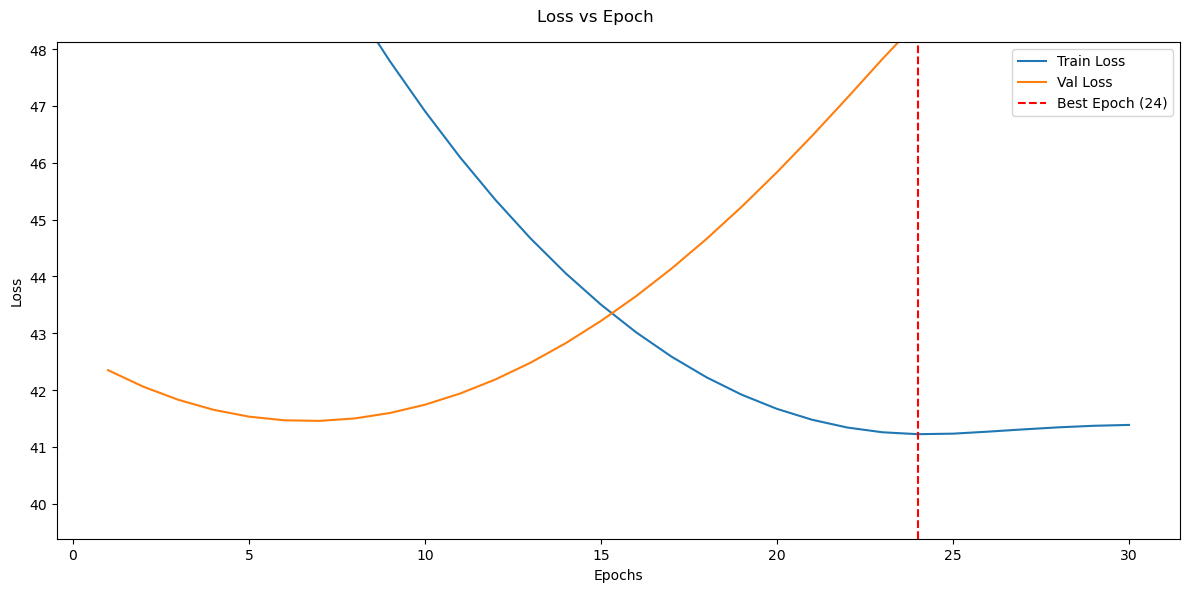

In [ ]:
bs = 30000
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)[2022, 2023, 2024]
#train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.8)
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2023, 2024], year_column = -2, bs = bs, n_channels = n_channels, train_proportion=0.8)
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
save_name = 'NN_response_DE_no_day5'
model= nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG=KG, KG2=KG2)
criterion = problist_square_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay = 0.0001)
#optimizer = torch.optim.ASGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
GDD_params = [0.31621224, 7.37066436, 22.88481424, 39.40562477]
model = initialise_as_GDD(model, *GDD_params, n_channels=5)
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

0 40.91984176635742 46.981781005859375
5 40.85856246948242 46.66337966918945
10 40.78241729736328 46.750579833984375
15 40.70802688598633 46.612083435058594
20 40.63454055786133 46.25189208984375
25 40.56239318847656 46.090126037597656


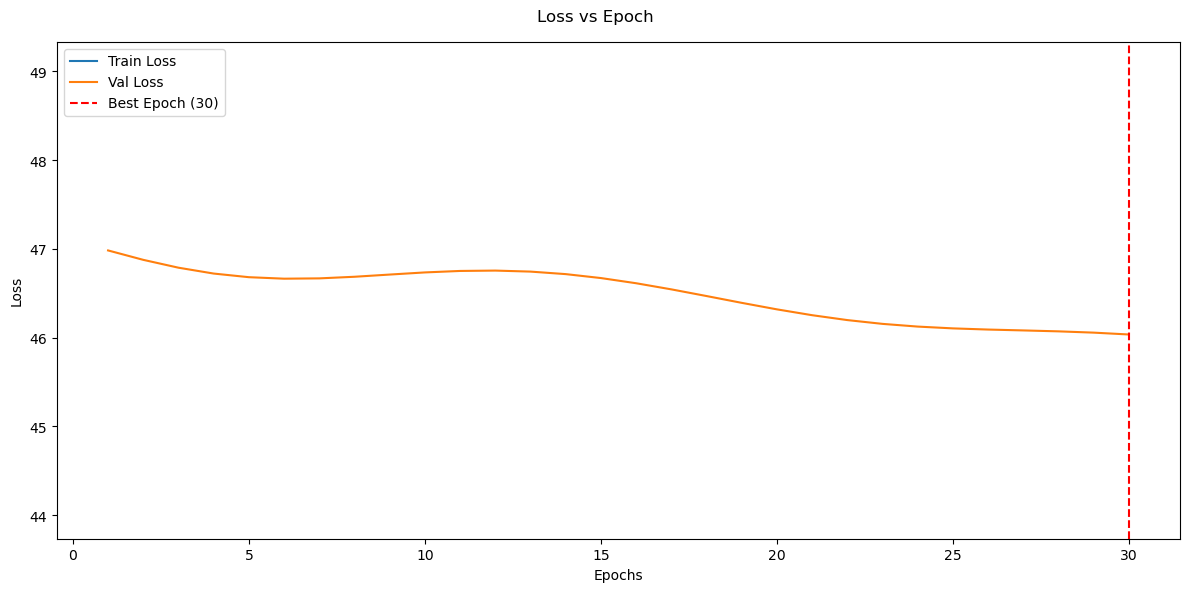

In [7]:
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name + '_more_epochs', CNN = False, bce=True)

torch.Size([939, 163]) torch.Size([939, 163, 1])
R^2 value for model: 0.3444226384162903
Bias: 3.3513643741607666
Variance of modelled values: 29.244579315185547


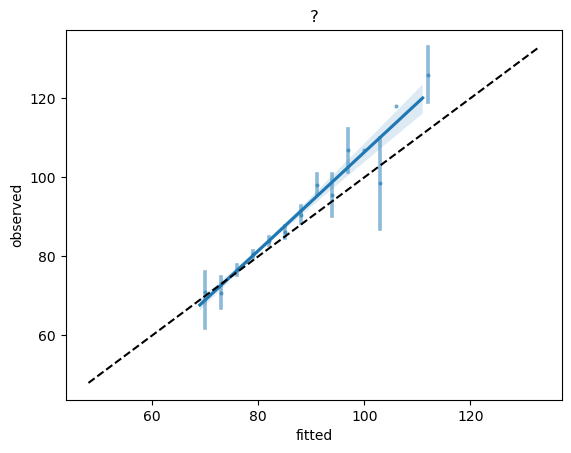

In [37]:
model = load_model(save_name, model)
with torch.no_grad():
    plot_fitted_observed_TS(model, val_dl, bce=True, CNN=False, title='?', MMD=False)

In [80]:
bs = 30000
n_channels = 5
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16#day2 -> 8#day -> 16 #day3 ->4
num_layers = 4#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False
KG2 = True
CNN = False
bce = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)
epochs = 500
lr = 0.001
GDD_init = [[0.33255554, 7.01088182, 23.30372493, 39.15531463],
            [0.5211015 , 7.97262452, 26.93599014, 39.03618276],
            [0.32364492, 7.77869448, 23.14973298, 39.31765333],
            [0.36357164, 7.39815342, 24.93931749, 39.26584633],
            [0.3354603 , 7.12958798, 24.48095047, 39.61850868],
            [0.32169801, 7.0014374 , 23.95026893, 39.29402994]]
year_folds = [list(range(1991 + 6*n, 1991 + 6*n + 6)) for n in range(5)] + [[2021, 2022, 2023, 2024]]
loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_year_crossval(year_folds, temp_NDVI_series_DE, NDVI_labels_DE, 
                                                                                                              nn_temp_response, 
                                                                                                        epochs, bs, model_args, 
                                                                                                        lr = lr, 
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, n_channels = n_channels,
                                                                                                        custom_loss=problist_square_loss, DTF = False,
                                                                                                        GDD_init=GDD_init, verbose=True)

Fold 1
[0.33255554, 7.01088182, 23.30372493, 39.15531463]
0 39.845680236816406 62.41814422607422
1 44.59663009643555 59.63982391357422
2 43.24580001831055 51.49837875366211
48 38.34069061279297 45.73033142089844
49 38.28206253051758 46.31352615356445
50 38.27458953857422 46.118492126464844
51 38.2401237487793 45.44850540161133
52 38.214447021484375 45.27507400512695
98 37.66887664794922 44.78419876098633
99 37.65564727783203 44.82259750366211
100 37.64269256591797 44.711708068847656
101 37.62919235229492 44.715511322021484
102 37.61547088623047 44.73961639404297
148 37.09388732910156 43.590782165527344
149 37.084049224853516 43.73839569091797
150 37.08033752441406 43.341861724853516
151 37.081085205078125 43.941043853759766
152 37.08573532104492 43.1374626159668
198 36.83203125 43.107784271240234
199 36.82805252075195 43.46141052246094
200 36.825294494628906 43.06086730957031
201 36.82466506958008 43.5501823425293
202 36.82730484008789 42.934391021728516
248 37.33988571166992 44.360862

In [ ]:
err_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'accumulated NN response', 'DE', '5-fold year CV')
err_df.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\NEW_error_df_NN.csv')

In [77]:
GDD_params = [0.33255554, 7.01088182, 23.30372493, 39.15531463]#[0.31621224, 7.37066436, 22.88481424, 39.40562477]
model = initialise_as_GDD(model, *GDD_params, n_channels=5)

0 276.7798156738281 270.7234802246094
5 42.76600646972656 47.19794845581055
10 51.994205474853516 46.777061462402344
15 40.95277404785156 54.43132400512695
20 41.64373016357422 52.39447021484375
25 40.89780807495117 46.53742980957031


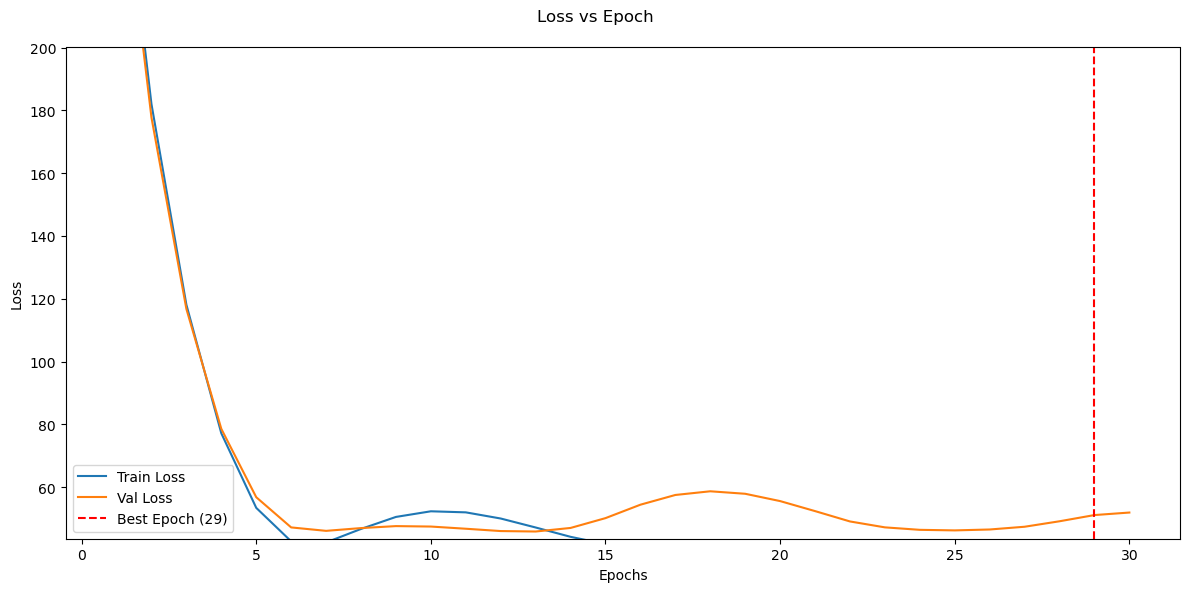

In [78]:
#for param in [model.u0, model.u1, model.u2, model.u3, model.u4, model.fc.bias]: #[model.u1, model.u2, model.u3]:
#    param.requires_grad = False
# Loss function and optimizer
criterion = nn.BCELoss() # nn.NLLLoss() # nn.BCELoss() #  # For multi-class classification
criterion = problist_square_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay = 0.0001)
#optimizer = torch.optim.ASGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

torch.Size([7428, 163]) torch.Size([7428, 163, 1])
R^2 value for model: 0.3852505087852478
Bias: 13.381333351135254
Variance of modelled values: 85.81896209716797


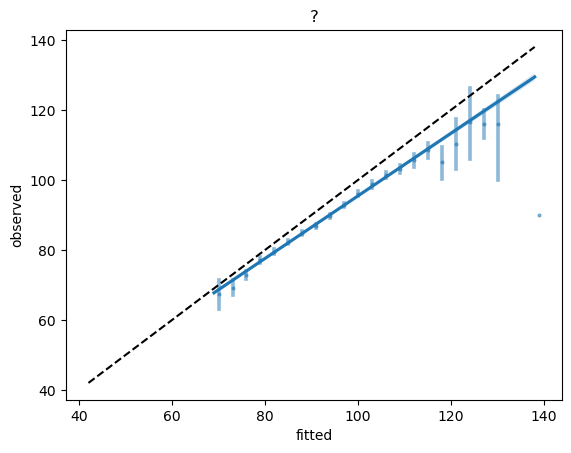

In [79]:
with torch.no_grad():
    plot_fitted_observed_TS(model, val_dl, bce=True, CNN=False, title='?', MMD=False)

0 40.165401458740234 52.97562026977539
5 38.957862854003906 44.785926818847656
10 38.52963638305664 48.39216232299805
15 38.40574264526367 44.66185760498047
20 38.263858795166016 45.8461799621582
25 38.1108283996582 45.924442291259766


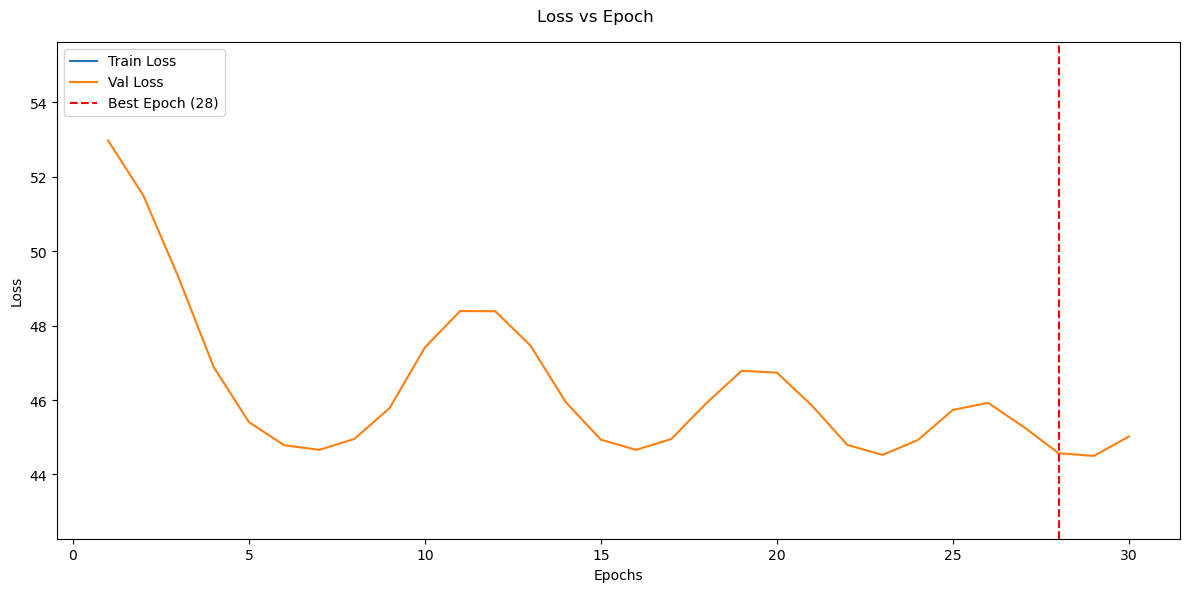

In [70]:
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

In [111]:
#epochs = 20
#fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

torch.Size([7428, 163]) torch.Size([7428, 163, 1])
R^2 value for model: 0.41930484771728516
Bias: 9.734131813049316
Variance of modelled values: 70.65897369384766


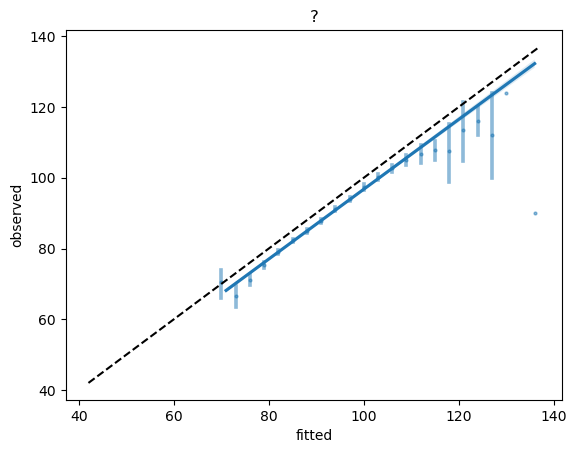

In [ ]:
with torch.no_grad():
    plot_fitted_observed_TS(model, val_dl, bce=True, CNN=False, title='?', MMD=False)

In [97]:
import copy
temp_NDVI_series_DE2 = copy.deepcopy(temp_NDVI_series_DE)
temp_NDVI_series_DE2[:, :-2, :] += torch.tensor(np.random.normal(0, 0.5, (temp_NDVI_series_DE2.shape[0], temp_NDVI_series_DE2.shape[1] - 2, temp_NDVI_series_DE2.shape[2])))
#temp_NDVI_series_DE2[:, 0, :] += torch.tensor(np.random.normal(0, 1, (temp_NDVI_series_DE2.shape[0], temp_NDVI_series_DE2.shape[2])))

In [98]:
temp_NDVI_series_DE_new = torch.concat((temp_NDVI_series_DE, temp_NDVI_series_DE2), dim=0)
NDVI_labels_DE_new = torch.concat((NDVI_labels_DE, NDVI_labels_DE), dim=0)

In [29]:
bs = 500
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
#train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.8)
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2022, 2023, 2024], year_column = -2, bs = bs, n_channels = n_channels, train_proportion=0.8)
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 4#day2 -> 8#day -> 16 #day3 ->4
num_layers = 8#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False

save_name= 'NN_response_DE_no_day5'#'NN_response_DE'

model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG = KG)
for param in [model.u0, model.u4]: #[model.u1, model.u2, model.u3]:
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() # nn.NLLLoss() # nn.BCELoss() #  # For multi-class classification
criterion = problist_square_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay = 0.0001)
#optimizer = torch.optim.ASGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
epochs = 500
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

0 7755.9344549644875 6899.827120111792


KeyboardInterrupt: 

In [100]:
train_dl, val_dl_old = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2022, 2023, 2024], year_column = -2, bs = bs, n_channels = n_channels, train_proportion=0.8)

OrderedDict([('u0', tensor([200.])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('u4', tensor([50.])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-1.1324e-01, -7.6590e-02, -3.8780e-02, -1.4693e-01,  1.0930e-01],
        [-3.2798e-02, -3.1632e-03, -1.0555e-02, -1.7551e-01,  3.2250e-02],
        [ 6.0203e-02,  1.2229e-01, -7.7857e-02, -1.0692e-01, -1.3647e-01],
        [-1.0210e-01,  1.2253e-01, -1.4263e-01,  6.7163e-02,  5.8810e-02],
        [ 1.1424e-01,  8.3513e-02,  1.0089e-01,  2.6344e-03, -3.6682e-02],
        [ 1.2123e-01,  1.5455e-01,  1.5735e-01,  7.7015e-02, -1.7165e-01],
        [ 1.2805e-02,  1.0339e-01,  1.0315e-02,  2.7381e-02,  1.6310e-01],
        [-9.7656e-02,  1.4042e-01,  7.5368e-02, -3.4083e-02, -5.2849e-02],
        [-1.1178e-01,  8.3761e-02, -7.0898e-02,  1.4139e-01, -8.1721e-02],
        [-1.4767e-01, -1.5896e-01, -7.2926e-04,  4.5433e-02,  1.0430e-01],
        [ 1.0104e-01, -1.6777e-01,  5.3025e-02,  1.5723e-01,  4.8288e-02],
    

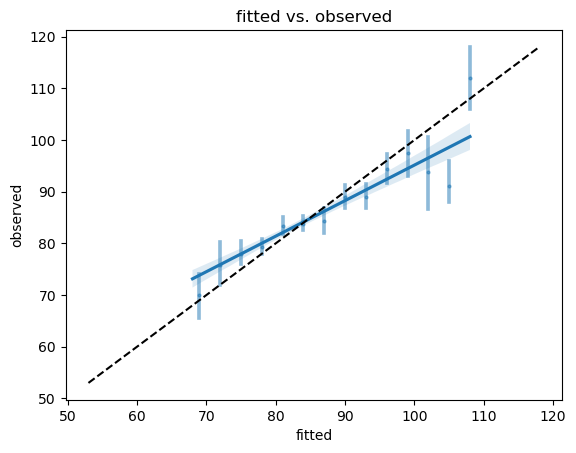

In [101]:
#save_name= 'NN_response_DE_no_day4'
plot_from_saved(save_name, model, val_dl_old, method = 'regression', bce=True, CNN=False)#

In [29]:
bs = 30000
n_channels = 5

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 4
output_dim = 1  # Example: 5 classes
bce = True
CNN = False
KG = False
KG2 = True

epochs = 2#500
#train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, KG2)

model_class = nn_temp_response

year_folds = [list(range(1991 + 6*n, 1991 + 6*n + 6)) for n in range(5)] + [[2021, 2022, 2023, 2024]]

loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_year_crossval(year_folds, temp_NDVI_series_DE, NDVI_labels_DE, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='MSE', custom_loss=problist_square_loss, bce=bce, CNN=CNN, lr = 0.001)

Fold 1
torch.Size([7428, 163]) torch.Size([7428, 163, 1])
Fold 2
torch.Size([5232, 163]) torch.Size([5232, 163, 1])
Fold 3
torch.Size([4697, 163]) torch.Size([4697, 163, 1])
Fold 4
torch.Size([4191, 163]) torch.Size([4191, 163, 1])
Fold 5
torch.Size([3594, 163]) torch.Size([3594, 163, 1])
Fold 6
torch.Size([2001, 163]) torch.Size([2001, 163, 1])


In [30]:
R2s

[0.46236133575439453,
 -7.873197555541992,
 0.4039318561553955,
 -0.6661123037338257,
 0.47218644618988037,
 0.38663971424102783]

In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

In [14]:
loss_values_outlier = np.array(loss_values_raw)[[0, 1, 3, 4]]
R2s_outlier = np.array(R2s_raw)[[0, 1, 3, 4]]
Biases_outlier = np.array(Biases_raw)[[0, 1, 3, 4]]
Variances_outlier = np.array(Variances_raw)[[0, 1, 3, 4]]
score = np.mean(loss_values_outlier)
score_stde = np.std(loss_values_outlier)/np.sqrt(5)
R2_score = np.mean(R2s_outlier)
R2_stde = np.std(R2s_outlier)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_outlier)**2)
Bias_stde = np.std(np.array(Biases_outlier)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_outlier)
Variance_stde = np.std(Variances_outlier)/np.sqrt(5)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model ####
loss 0.08158170132949823 +/- 0.0011735902870786945
R2 0.539517268538475 +/- 0.009512910996988278
Bias 1.4095807075500488 +/- 0.4881840389611978
Variance 69.87857913970947 +/- 1.9365423397382626


In [16]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model ####
loss 0.0857873895036034 +/- 0.0017501291191818161
R2 0.5025057911872863 +/- 0.03304838901787813
Bias 5.320456504821777 +/- 2.65924510467014
Variance 65.17378997802734 +/- 2.6935101650037243


In [15]:
bs = 250
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 4
output_dim = 1  # Example: 5 classes
bce = True
CNN = False
KG = False

epochs = 2500
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = nn_temp_response

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=bce, CNN=CNN, lr = 0.001)

Fold 1
Loss: 0.10632183402776718
Fold 2
Loss: 0.10671341419219971
Fold 3
Loss: 0.07519201934337616
Fold 4
Loss: 0.09973899275064468
Fold 5
Loss: 0.09799212962388992


In [16]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model SSA ####
loss 0.1493362158536911 +/- 0.054862736700971436
R2 0.4223050832748413 +/- 0.06124715833323278
Bias 3.0792195796966553 +/- 1.7015497732485039
Variance 74.30063247680664 +/- 10.535685162350985


In [19]:
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
epochs = 3000
KG = False
regression = False
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 4
output_dim = 1 
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_crossval(5, train_ds, nn_temp_response, epochs, bs, model_args, lr = 0.01, loss = 'MSE', CNN=False, bce=True, custom_loss=criterion, DTF = False, obs_method=False)

Fold 1
Loss: 0.08006106317043304
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 2
Loss: 0.08299506455659866
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 3
Loss: 0.091669462621212
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 4
Loss: 0.08720815926790237
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 5
Loss: 0.0792701467871666
torch.Size([50, 163]) torch.Size([50, 163, 1])


In [35]:
err_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'accumulated NN response', 'SSA', 'Transfer DE to SSA')

In [37]:
error_df_full = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')
err_df_full = pd.concat([error_df_full, err_df], ignore_index=True)
err_df_full.drop(['Unnamed: 0'], axis = 1, inplace = True)
err_df_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')

In [39]:
ds_inputs_SSA['observed time to beginning of flowering'].std()

12.342406717455804

0 0.20070478320121765 0.1972217857837677
5 0.17222975194454193 0.26452574133872986
10 0.1203250139951706 0.21172836422920227
15 0.1254911869764328 0.13188336789608002
20 0.10819168388843536 0.10779127478599548
25 0.10717657953500748 0.12595246732234955
30 0.10609320551156998 0.1459871083498001
35 0.10350611060857773 0.13650380074977875
40 0.10435164719820023 0.12099400162696838
45 0.10372642427682877 0.11523743718862534
50 0.10306055843830109 0.11556493490934372
55 0.10298377275466919 0.11853209882974625
60 0.10287643224000931 0.1212286576628685
65 0.1025882214307785 0.12190330028533936
70 0.10247145593166351 0.12152165174484253
75 0.10224862396717072 0.12180918455123901
80 0.10206149518489838 0.1208568811416626
85 0.10182983428239822 0.11823616921901703
90 0.10154758393764496 0.1155490130186081
95 0.10090300440788269 0.13161486387252808
100 0.10082988440990448 0.10060412436723709
105 0.10111568123102188 0.10539599508047104
110 0.10087910294532776 0.10889188200235367
115 0.099609002470

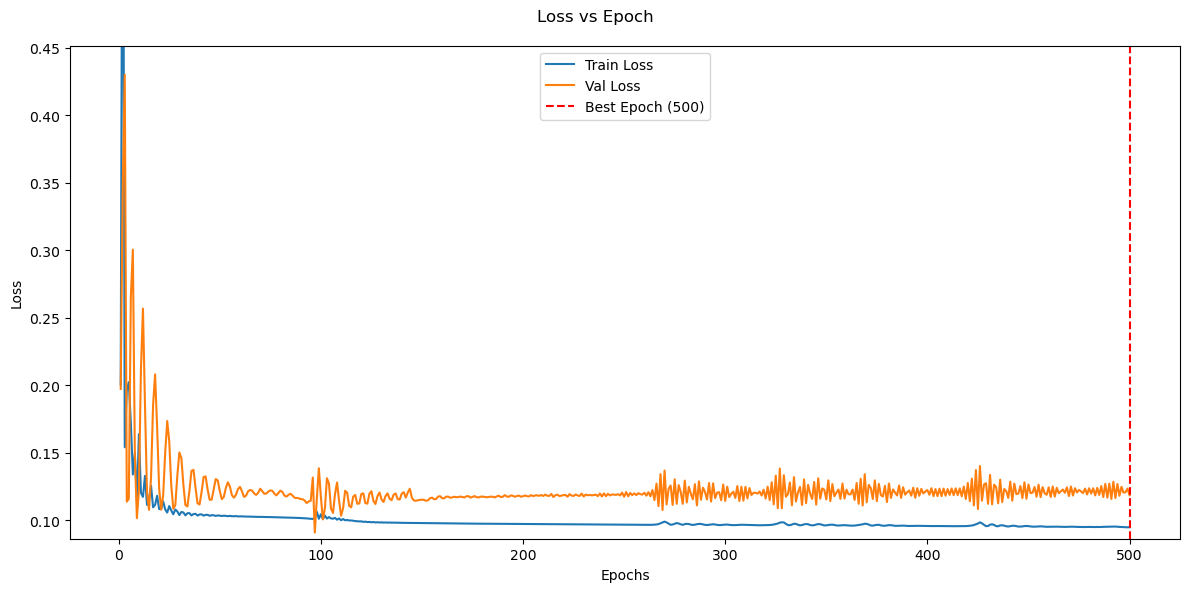

In [ ]:
bs = 500
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.99)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 4
output_dim = 1  # Example: 5 classes
KG = False

save_name= 'NN_response_SSA_no_day3'#'NN_response_DE'

model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG = KG)
for param in [model.u0]: #[model.u1, model.u2, model.u3]:
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() # nn.NLLLoss() # nn.BCELoss() #  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 500
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

torch.Size([251, 163]) torch.Size([251, 163, 1])
R^2 value for model: 0.532931923866272
Bias: 0.042918819934129715
Variance of modelled values: 77.2651596069336


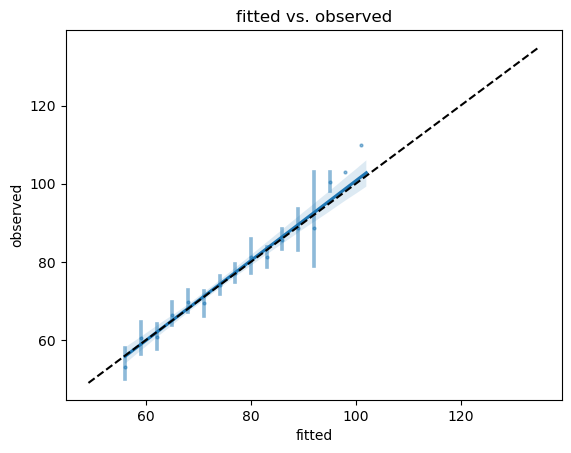

In [133]:
plot_from_saved(save_name, model, train_dl, method = 'regression', bce=True, CNN=False)#

0 75.45345978923382 60.34364424520017
5 76.41149509813702 67.91208019144175
10 79.82674916139905 93.11507824970838
15 67.50074595926243 57.229320128914885
20 72.90265138280556 55.89584771027031
25 69.63979791810851 57.24254336853627
30 69.18970425218477 55.90380017743364
35 77.83069450258165 55.58332656830373
40 73.50829431801414 55.425083182883874
45 68.26317715797937 56.95381590238021


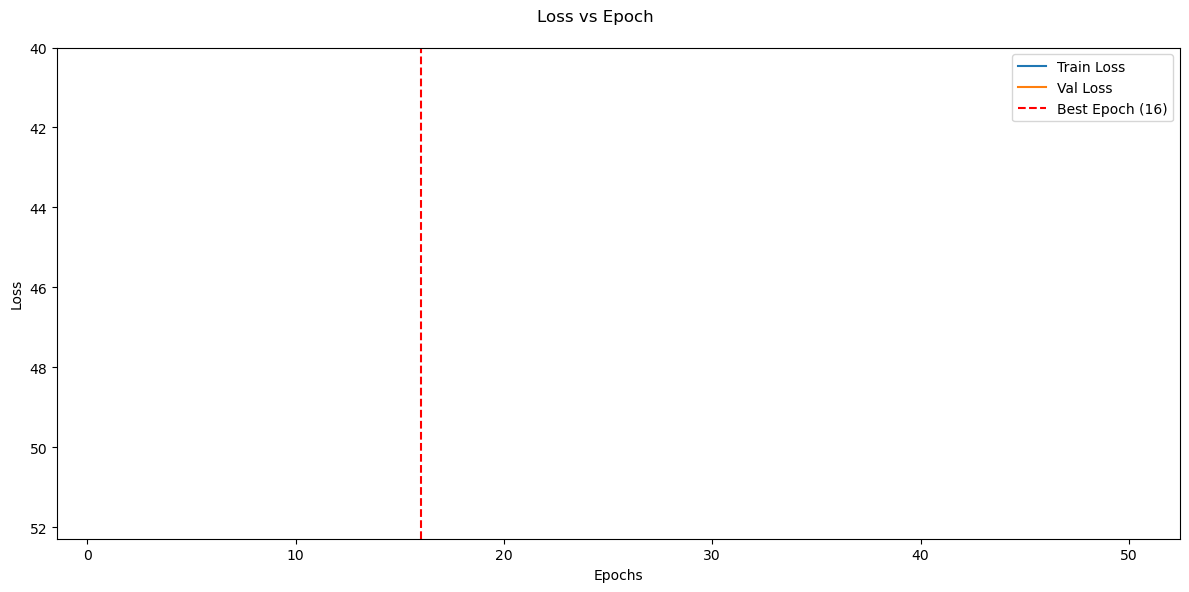

In [ ]:
#epochs = 50
#fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

OrderedDict([('u0', tensor([200.])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('u4', tensor([10.])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[ 0.2146, -0.1149, -0.2991,  0.3260,  0.1481],
        [ 0.0802,  0.2714, -0.3409,  0.2907,  0.2163],
        [-0.2066,  0.0636, -0.3385, -0.0745, -0.0090],
        [ 0.1823,  0.2823,  0.0117,  0.0856, -0.3232],
        [ 0.2043, -0.2844,  0.2926,  0.2167,  0.2795],
        [-0.0639, -0.1868,  0.1644,  0.0408,  0.1877],
        [-0.2122,  0.1931, -0.2324,  0.3330, -0.3037],
        [ 0.2220,  0.0172, -0.1483, -0.0091,  0.0582],
        [ 0.0425,  0.1096, -0.2036, -0.1354,  0.0690],
        [ 0.1589,  0.3106,  0.1300, -0.3463,  0.1701],
        [-0.3021,  0.0738,  0.2999,  0.3085,  0.0983],
        [ 0.1786, -0.3324, -0.0186, -0.1306,  0.0458],
        [-0.2464,  0.3386,  0.3332,  0.2225,  0.0312],
        [ 0.0353, -0.1375, -0.1934, -0.3207, -0.2343],
        [ 0.3027,  0.1714,  0.1431,  0.0656,  0.0389],
    

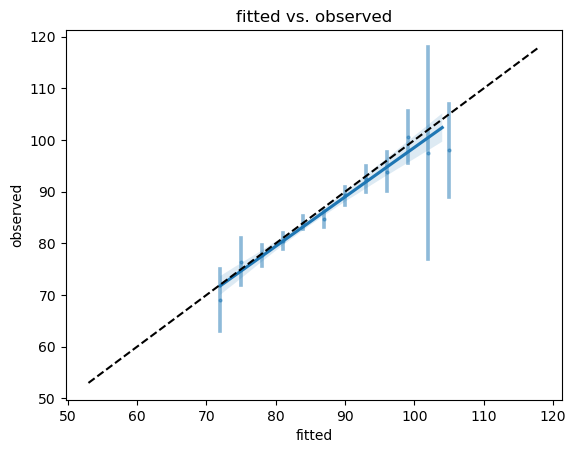

In [26]:
#save_name= 'NN_response_DE_no_day4'
plot_from_saved(save_name, model, val_dl, method = 'regression', bce=True, CNN=False)#

In [40]:
def get_comp_frame(savename, model, dl, bce=False, CNN=False, title = 'fitted vs. observed', MMD = False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    TS_model = model
    list_logs = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    print(logs.shape, torch.cat(list_logs, dim=0).shape)
    if bce:
        fitted = torch.round(logs)
    else:
        fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_days = L - fitted.sum(dim=1)
    observed = torch.cat(list_observed)
    observed_days = L - observed.sum(dim=1)
    comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [18]:
cf = get_comparison_frame(save_name, model, val_dl, bce=True, CNN=False)#

In [20]:
cf['fitted'].std()

6.263402938842773

In [55]:
save_name= 'NN_response_DE_no_day2'#'NN_response_DE'
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, save_name + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [181]:
np.array(vals_list).shape

(500, 100)

In [329]:
x2.squeeze()-vals

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_10872\3703562482.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x2.squeeze()-vals


tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
         0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031, -0.0031,
        -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031,
        -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031, -0.0031,
        -0.0031, -0.0031, -0.0031, -0.00

In [313]:
(model.fc.weight.data.squeeze()*model.layer8.bias.data).sum()

tensor(-0.0329)

In [ ]:
model.fc.weight.data.squeeze()

tensor([[ 8.8002e-04, -7.8018e-04, -6.1761e-05,  7.8139e-02,  2.2795e-02,
          2.7754e-02,  2.1979e-02,  8.1013e-02]])

In [279]:
np.mean(np.array(vals_list), axis=0)

array([-0.02297024, -0.02297024, -0.02297024, -0.02297024, -0.02297024,
       -0.02297024, -0.02297024, -0.02297024, -0.02297024, -0.02297024,
       -0.02297024, -0.02297024, -0.02297024, -0.02297024, -0.02297023,
       -0.02297023, -0.02297023, -0.02297023, -0.02297023, -0.02297023,
       -0.02297023, -0.02297023, -0.02297023, -0.02297023, -0.02297023,
       -0.02297022, -0.02297022, -0.02297022, -0.02297022, -0.02297022,
       -0.02297022, -0.02297022, -0.02297022, -0.02297022, -0.02297022,
       -0.02297022, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.02297021, -0.02297021, -0.02297021, -0.02297021,
       -0.02297021, -0.0229702 , -0.0229702 , -0.0229702 , -0.0229702 ,
       -0.0229702 , -0.0229702 , -0.0229702 , -0.0229702 , -0.02

In [286]:
model.fc.bias#.data

Parameter containing:
tensor([-0.0230], requires_grad=True)

In [234]:
model.layer3.weight.data

tensor([[0.9478, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

In [122]:
vals_LQ

array([0.0003113, 0.0003113, 0.0003113, 0.0003113, 0.0003113, 0.0003113,
       0.0003113, 0.0003113], dtype=float32)

In [106]:
np.quantile(np.array(vals_list), 0.9, axis=0)

array([-0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02532625,
       -0.02532625, -0.02532625, -0.02532625, -0.02532625, -0.02

In [129]:
np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(120)]].values, 0.01)

np.float64(6.6684328604979655)

<BarContainer object of 5 artists>

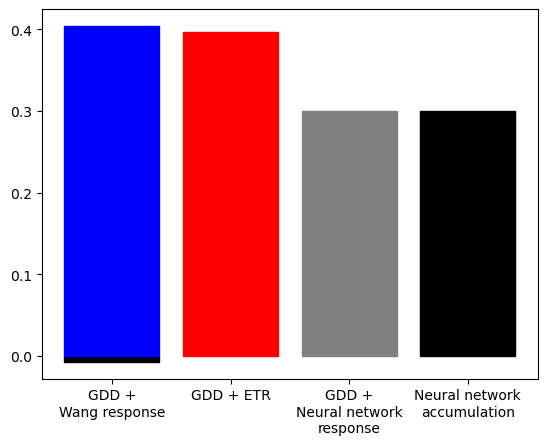

In [92]:
fig, ax = plt.subplots()
ax.bar(data=err_df, x='model', height='R2', color = ['k', 'red', 'blue', 'gray', 'k'], edgecolor = ['k', 'red', 'blue', 'gray', 'k'])

In [87]:
err_df

,model,R2
0,GDD +\nWang response,-0.007274
1,GDD + ETR,0.397185
2,GDD +\nWang response,0.404027
3,GDD +\nNeural network\nresponse,0.300667
4,Neural network\naccumulation,0.300000


In [15]:
#train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.01)
comparison_frame = get_comparison_frame(save_name, model, val_dl, bce=True, CNN=False, MMD=False, DTF = False, n_channels = n_channels, obs_method = False)

TypeError: get_comparison_frame() got an unexpected keyword argument 'MMD'

In [81]:
def plot_from_saved(savename, model, val_dl, method = 'regression', bce=False, CNN=False, title = 'fitted vs. observed', MMD=False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    #print(model.u4)
    #model.u4=nn.Parameter(torch.Tensor([0.02]))
    #print(model.u4)
    #print(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if method == 'cumulative':
        plot_fitted_observed_cumulative(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD)
    elif method == 'regression':
        plot_fitted_observed_TS(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD)
    elif method == 'histogram':
        plot_fitted_observed_histogram(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD)

In [76]:
for xb, yb in val_dl_SSA:
    print(yb.shape)

torch.Size([252, 163])


torch.Size([252, 163]) torch.Size([252, 163, 1])
R^2 value for model: 0.28196239471435547
Bias: 0.5565648078918457
Variance of modelled values: 22.250215530395508


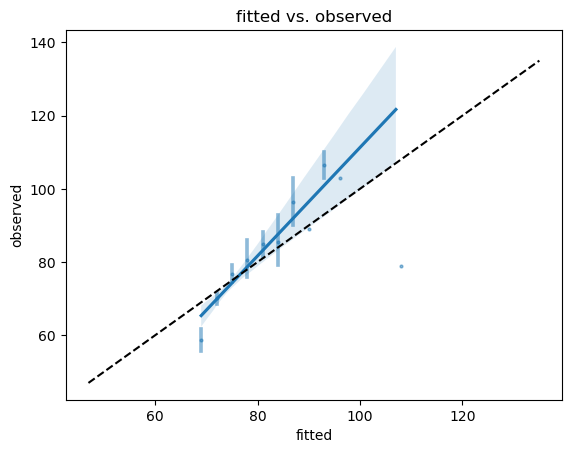

In [98]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.01)
plot_from_saved('KFold4', model, val_dl_SSA, method = 'regression', bce=True, CNN=False)#

In [29]:
R2s = []
Biases = []
Variances = []

RMSEs = []
STDs = []
Corrs = []

Mins = []
LQs = []
Medians = []
UQs = []
Maxs = []

comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

r2_score_model = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
bias_model = (comparison_frame['Error']).mean()
variance = comparison_frame['fitted'].var()

RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
STD = comparison_frame['fitted'].std() 
Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

RMSEs.append(RMSE)
STDs.append(STD)
Corrs.append(Corr)

Mins.append(comparison_frame['Error'].min())
LQs.append(comparison_frame['Error'].quantile(0.25))
Medians.append(comparison_frame['Error'].median())
UQs.append(comparison_frame['Error'].quantile(0.75))
Maxs.append(comparison_frame['Error'].max())

R2s.append(r2_score_model)
Biases.append(bias_model)
Variances.append(variance)

0 0.09037242921541684 0.10456027343441239
5 0.08992410350411305 0.1032807466722344
10 0.08961512309671998 0.102224383765817
15 0.08925422871609769 0.10115735964270858
20 0.0889349236885529 0.10146962047868235
25 0.08862703296483329 0.09941004666040211


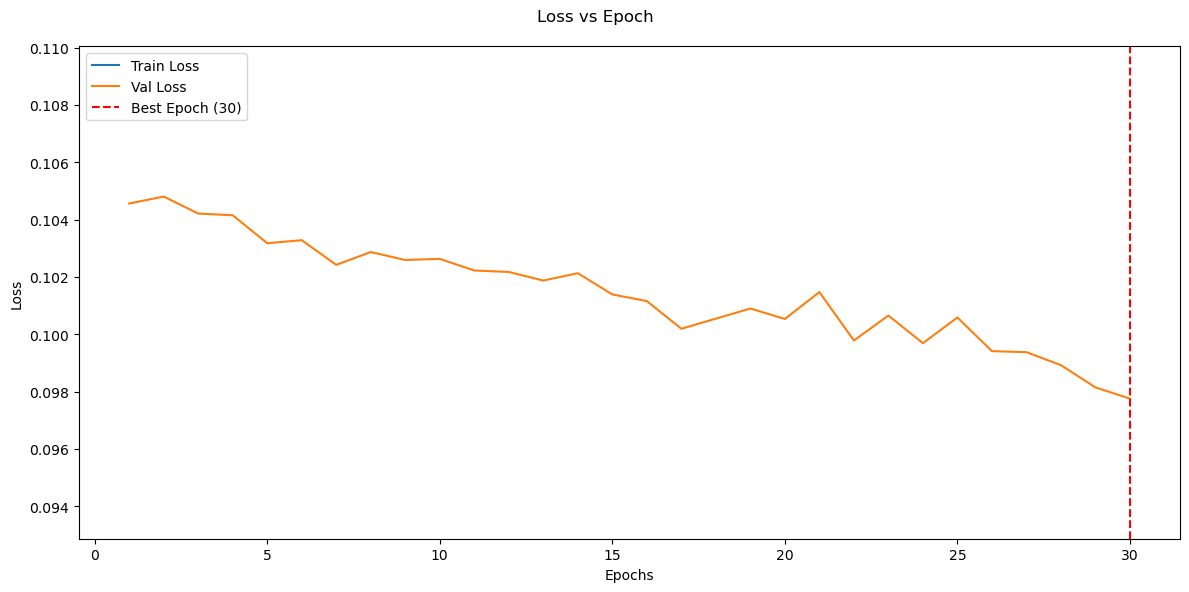

In [18]:
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

OrderedDict([('u0', tensor([1.3818])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('u4', tensor([0.7990])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-0.2404, -0.1111, -0.0454,  0.1936, -0.1655,  0.2254],
        [ 0.0169,  0.1593, -0.2032, -0.1482, -0.2339,  0.1009],
        [ 0.2236,  0.1397, -0.2136,  0.0487, -0.0030,  0.2439],
        [ 0.0247, -0.0894,  0.0249,  0.1936, -0.1072,  0.1596],
        [ 0.2204,  0.2266,  0.1290, -0.0725, -0.1771,  0.1854],
        [-0.1598, -0.1249, -0.1199,  0.1603,  0.1980, -0.0941],
        [ 0.0595, -0.1074, -0.1272,  0.0507,  0.1801,  0.0470],
        [ 0.1084, -0.0007,  0.0567, -0.1048, -0.0686,  0.0260],
        [-0.1499,  0.2432, -0.0648,  0.0694, -0.1028, -0.2424],
        [ 0.2043,  0.0965, -0.2228, -0.1323,  0.1925,  0.0979],
        [ 0.2374, -0.0669, -0.0016, -0.0945, -0.1193, -0.2051],
        [-0.1734,  0.1449, -0.1191,  0.1223, -0.1977,  0.0706],
        [-0.1951, -0.0595, -0.2058, -0.0386, -0.0839, -0

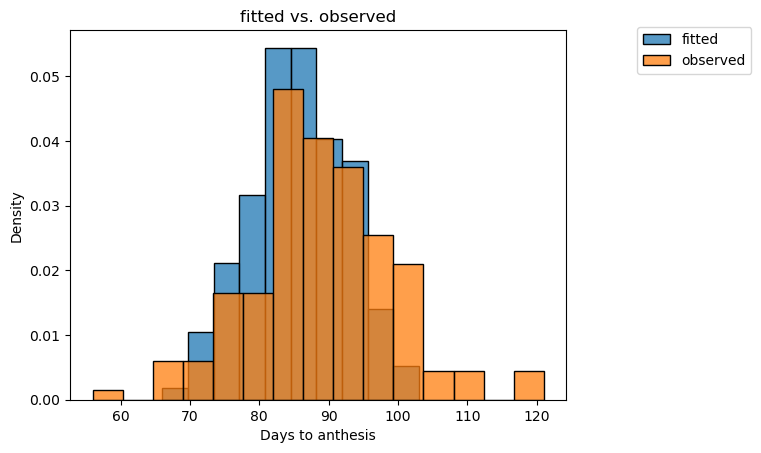

In [17]:
plot_from_saved(save_name, model, val_dl, method = 'histogram', bce=True, CNN=False)#

In [46]:
for x, y in train_dl:
    print(len(x))

500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
299


In [51]:
input_dim = 4
savename = 'NN_response_SSA' #'LSTM_KG_SAT_pp'save_name = 'CCNN_SAT_pp_KG'
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, savename + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG =True) #LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim)
model.load_state_dict(checkpoint['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in [model.u0, model.u1, model.u2, model.u3, model.u4, model.p0]:
    param.requires_grad = True

RuntimeError: Error(s) in loading state_dict for nn_temp_response:
	Missing key(s) in state_dict: "u4". 

0 0.3747577965259552 53.4495735168457
5 53.58411407470703 53.4495735168457
10 53.58411407470703 53.4495735168457
15 53.58411407470703 53.4495735168457
20 53.58411407470703 53.4495735168457
25 53.58411407470703 53.4495735168457
30 53.58411407470703 53.4495735168457
35 53.58411407470703 53.4495735168457
40 53.58411407470703 53.4495735168457
45 53.58411407470703 53.4495735168457
50 53.58411407470703 53.4495735168457
55 53.58411407470703 53.4495735168457
60 53.58411407470703 53.4495735168457
65 53.58411407470703 53.4495735168457
70 53.58411407470703 53.4495735168457
75 53.58411407470703 53.4495735168457
80 53.58411407470703 53.4495735168457
85 53.58411407470703 53.4495735168457
90 53.58411407470703 53.4495735168457
95 53.58411407470703 53.4495735168457
100 53.58411407470703 53.4495735168457
105 53.58411407470703 53.4495735168457
110 53.58411407470703 53.4495735168457
115 53.58411407470703 53.4495735168457
120 53.58411407470703 53.4495735168457
125 53.58411407470703 53.4495735168457
130 53.

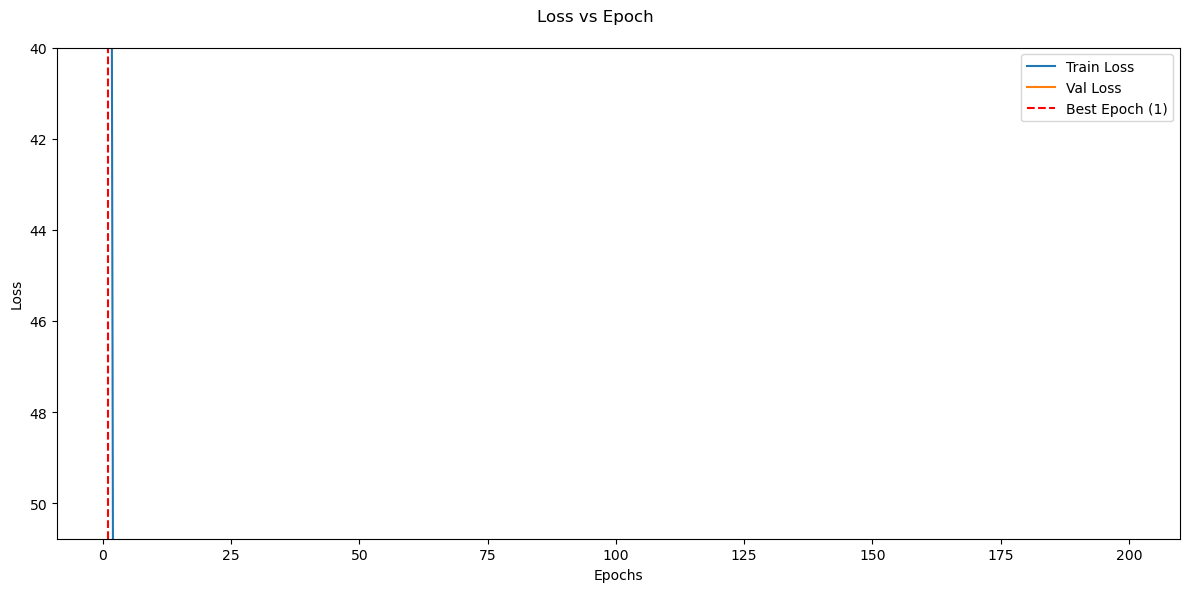

In [52]:
bs = 500
n_channels = 4
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.5)
save_name = 'nn_KG_SSA_TL'
# Loss function and optimizer
criterion = criterion = nn.BCELoss()#nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 200
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN=False, bce = True)

In [49]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = nn_temp_response
savename =  'NN_response_DE'
epochs = 200
bs = 500
input_dim = 4
hidden_dim = 16
num_layers = 4
output_dim = 1
KG = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, savename, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=False, bce=True)

Fold 1
Loss: 0.11896631866693497
Fold 2
Loss: 0.11890595406293869
Fold 3
Loss: 0.11161382496356964
Fold 4
Loss: 0.11943992227315903
Fold 5
Loss: 0.10649867355823517


In [92]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = nn_temp_response
save_name= 'NN_response_DE_no_day'
epochs = 200
bs = 500
input_dim = 5
hidden_dim = 16
num_layers = 4
output_dim = 1
KG = False
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, save_name, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=False, bce=True)

Fold 1
Loss: 0.12871979176998138
Fold 2
Loss: 0.10623729974031448
Fold 3
Loss: 0.13243165612220764
Fold 4
Loss: 0.13086050748825073
Fold 5
Loss: 0.12835103273391724


In [93]:
R2s

[0.3179613947868347,
 0.22253692150115967,
 0.3240765929222107,
 0.16850709915161133,
 0.3345268964767456]

In [ ]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = nn_temp_response
savename =  'NN_response_DE'
epochs = 200
bs = 500
input_dim = 4
hidden_dim = 16
num_layers = 4
output_dim = 1
KG = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, savename, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=False, bce=True)

In [50]:
np.mean(R2s)

0.3838975191116333

OrderedDict([('u0', tensor([3.0300])), ('u1', tensor([0.4097])), ('u2', tensor([0.0449])), ('u3', tensor([-0.5913])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[ 0.1043, -0.1732, -0.0477,  0.1512],
        [-0.0545,  0.0497, -0.2428,  0.0014],
        [ 0.1945,  0.0507, -0.1964,  0.0299],
        [-0.2144, -0.1459, -0.0323, -0.0244],
        [-0.2213, -0.2290, -0.0947,  0.2399],
        [ 0.0758,  0.1267,  0.0760,  0.0709],
        [ 0.0857,  0.0354,  0.0365, -0.1485],
        [-0.1117, -0.0730,  0.0718, -0.1403],
        [-0.0883,  0.1695,  0.1737,  0.0485],
        [ 0.1216,  0.1737, -0.1048,  0.0343],
        [ 0.0709, -0.0815, -0.0661, -0.0558],
        [ 0.1102, -0.0238,  0.1316,  0.1946],
        [-0.0562,  0.0013, -0.1097,  0.2364],
        [-0.1537,  0.1375,  0.1374, -0.1491],
        [-0.0216,  0.2121,  0.0229, -0.1307],
        [ 0.2094,  0.1508,  0.1870,  0.1204],
        [-0.0817, -0.0098,  0.1564,  0.1775],
        [-0.2445,  0.2046, -0.1549, -0.0738],
        [

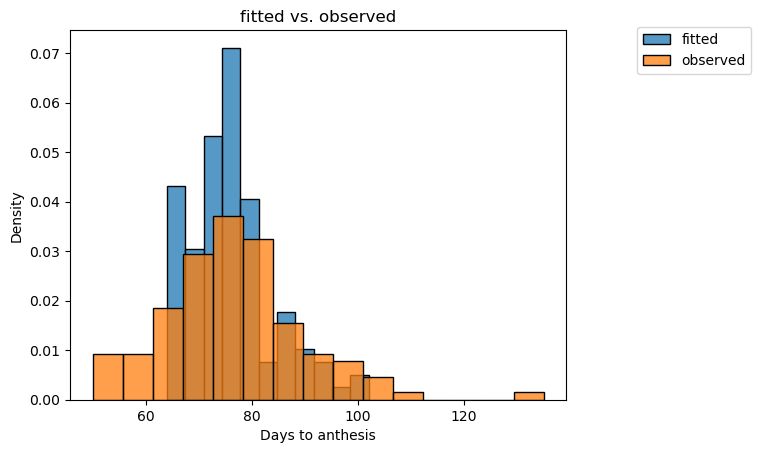

In [31]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl, method = 'histogram', bce=True, CNN=False)#

OrderedDict([('u0', tensor([1.1530])), ('u1', tensor([-0.1794])), ('u2', tensor([0.3816])), ('u3', tensor([-0.4020])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-0.1974, -0.2006, -0.0475,  0.2221],
        [ 0.0257, -0.0198, -0.0496,  0.0122],
        [ 0.1149, -0.2155,  0.1518,  0.1868],
        [-0.1645, -0.1128,  0.0752,  0.1435],
        [-0.2248,  0.2379, -0.0086, -0.0520],
        [-0.1826, -0.0774,  0.1675,  0.1776],
        [ 0.2482,  0.2398,  0.1657, -0.0479],
        [ 0.1480, -0.2085,  0.2146,  0.1298],
        [-0.0570, -0.1773, -0.0914,  0.0834],
        [-0.1016, -0.1098,  0.2369,  0.0051],
        [ 0.0644,  0.1220,  0.2233,  0.2405],
        [ 0.2089, -0.1299,  0.0426,  0.0930],
        [-0.0095,  0.0818, -0.1380,  0.2496],
        [-0.0396, -0.1339,  0.2145, -0.1666],
        [ 0.1908,  0.1698,  0.0816, -0.1312],
        [ 0.2103, -0.0689,  0.0935, -0.1742],
        [-0.0281,  0.1960, -0.1748,  0.0414],
        [-0.1968, -0.1785, -0.1091,  0.2427],
        

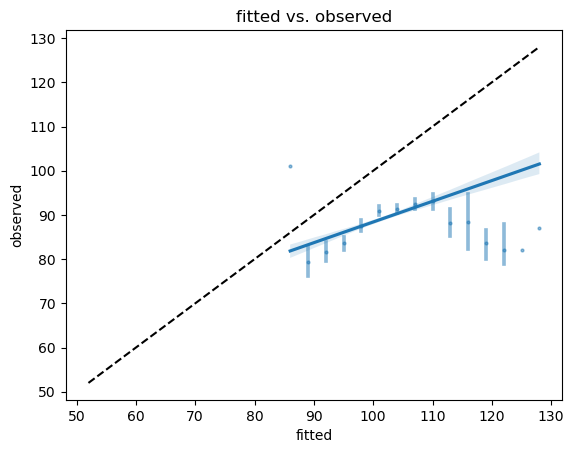

In [41]:
#save_name= 'Simple_NN_KG_SAT_pp'
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl_DE, method = 'regression', bce=bce, CNN=CNN)#

In [15]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
output_dim = 1  # Example: 5 classes

epochs = 100
model_class = nn_temp_response
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)

CNN = False
bce = True

k_folds = 5

for num_layers in [4, 8, 16]:
    for hidden_dim in [4, 8, 16]:
        print(num_layers, 'layers', ' hidden dim', hidden_dim)
        if num_layers == 4 and hidden_dim == 4:
            continue
        CNN_args = (input_dim, hidden_dim, num_layers, output_dim)
        loss_values, R2s, Biases, Variances = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, CNN_args, savename_prefix = 'KFold', loss = 'BCE', CNN=CNN, bce=bce)
        score = np.mean(loss_values)
        score_std = np.std(loss_values)
        R2_score = np.mean(R2s)
        R2_std = np.std(R2s)
        print(f'{num_layers} layers\nhidden dim {hidden_dim}\nloss {score} +/- {score_std}\nR2 {R2_score} +/- {R2_std}')

4 layers  hidden dim 4
4 layers  hidden dim 8
Fold 1
Loss: 0.09616621111788647
Fold 2
Loss: 0.09566244860446822
Fold 3
Loss: 0.09476258567863469
Fold 4
Loss: 0.09438741723520498
Fold 5
Loss: 0.09320732081260687
4 layers
hidden dim 8
loss 0.09493828170281887 +/- 0.002420975512318771
R2 0.37770284414291383 +/- 0.019117042911555693
4 layers  hidden dim 16
Fold 1
Loss: 0.09261867260383762
Fold 2
Loss: 0.09239977217391353
Fold 3
Loss: 0.09415661846640051
Fold 4
Loss: 0.09497429841538102
Fold 5
Loss: 0.09179341441275127
4 layers
hidden dim 16
loss 0.09486407761935563 +/- 0.004295512494431185
R2 0.3825199007987976 +/- 0.03583584992555995
8 layers  hidden dim 4
Fold 1
Loss: 0.0961160135534185
Fold 2
Loss: 0.10060566749309494
Fold 3
Loss: 0.09688205700984269
Fold 4
Loss: 0.09487669004143157
Fold 5
Loss: 0.09302868716818326
8 layers
hidden dim 4
loss 0.09687764126985862 +/- 0.003657330615980168
R2 0.3614853620529175 +/- 0.026865292197698572
8 layers  hidden dim 8
Fold 1
Loss: 0.09523385585723479

KeyboardInterrupt: 

4 layers
hidden dim 8
loss 0.09493828170281887 +/- 0.002420975512318771
R2 0.37770284414291383 +/- 0.019117042911555693

4 layers
hidden dim 16
loss 0.09486407761935563 +/- 0.004295512494431185
R2 0.3825199007987976 +/- 0.03583584992555995

8 layers
hidden dim 4
loss 0.09687764126985862 +/- 0.003657330615980168
R2 0.3614853620529175 +/- 0.026865292197698572

8 layers
hidden dim 8
loss 0.09825641053378115 +/- 0.0018010093072599591
R2 0.34743714332580566 +/- 0.039617697187614036

8 layers
hidden dim 16
loss 0.09622502034269967 +/- 0.0037492410465446847
R2 0.3490405440330505 +/- 0.0566075686691473

4 layers
hidden dim 4
loss 0.09671930811207077 +/- 0.0018048219953200194
R2 0.3694689631462097 +/- 0.017327979076895317

In [42]:
comparison_frame = get_comparison_frame(save_name, model, val_dl_DE, bce=bce, CNN=CNN)

In [43]:
comparison_frame['fitted'] = comparison_frame['fitted'] - comparison_frame['fitted'].mean()
comparison_frame['observed'] = comparison_frame['observed'] - comparison_frame['observed'].mean()

In [44]:
r2_score(comparison_frame['observed'] - comparison_frame['observed'].mean(), comparison_frame['fitted'] - comparison_frame['fitted'].mean()) #

-0.016082406044006348

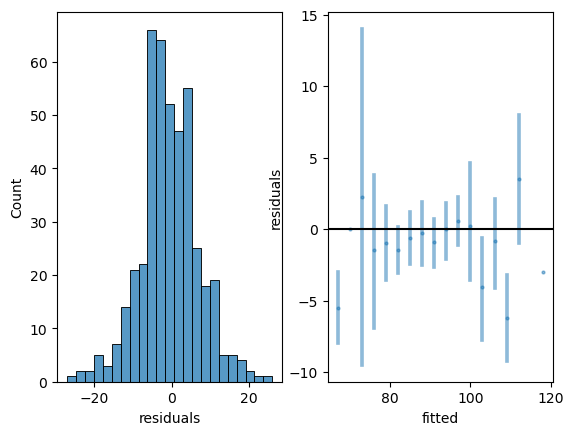

In [44]:
plot_residuals(comparison_frame)

In [43]:
def plot_residuals(comparison_frame):
    fig, axs = plt.subplots(1, 2)
    comparison_frame['residuals'] = comparison_frame['observed'] - comparison_frame['fitted']
    sns.histplot(comparison_frame['residuals'], ax = axs[0])
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['residuals'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['residuals'].min())
    
    sns.regplot(x='fitted', y='residuals', data = comparison_frame, ax=axs[1],
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
                fit_reg = False)
    axs[1].axhline(0, color = 'black')

In [18]:
class simple_nn_Classifier_KG(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(simple_nn_Classifier_KG, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4= nn.Linear(hidden_dim, hidden_dim)
        self.layer5 = nn.Linear(hidden_dim, hidden_dim)
        self.layer6= nn.Linear(hidden_dim, hidden_dim)
        self.layer7 = nn.Linear(hidden_dim, hidden_dim)
        self.layer8 = nn.Linear(hidden_dim, hidden_dim)
        self.layer9 = nn.Linear(hidden_dim, hidden_dim)
        self.layer10= nn.Linear(hidden_dim, hidden_dim)
        self.layer11 = nn.Linear(hidden_dim, hidden_dim)
        self.layer12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.u0 = torch.nn.Parameter(torch.Tensor([1]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        T_min = 9 + 2*(torch.tanh(self.u1))
        T_opt = 28 + 3*(torch.tanh(self.u2))
        T_max = 39 + torch.tanh(self.u3)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        #x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        #x = torch.nan_to_num(x)
        #x = x*(x >= T_min)*(x<= T_max)
        #print(x)
        #print(x, x.shape)
        # Make cumulative
        x[:, :, 0] = self.u0*torch.cumsum(x[:, :, 0], dim = 1)
        if self.input_dim == 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        # Forward pass through LSTM
        #x = torch.swapaxes(x, 1, 2)
        for i, linlayer in enumerate([self.input_layer, self.layer1, self.layer2, self.layer3, 
                                      self.layer4, self.layer5, self.layer6,
                                      self.layer7, self.layer8, self.layer9,
                                      self.layer10, self.layer11, self.layer12]):
            #print(i)
            #print(x.shape)
            #print(conv)
            x = linlayer(x)
            x = self.activation(x)
            #x = x[:, :, :-conv.padding[0]]
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = self.fc(x) # (batch, output_dim)
        if self.output_dim == 1:
            out_scores = self.sig(out_space)
        else:
            out_scores = F.log_softmax(out_space, dim=2)


        return out_scores

In [ ]:
bs = 250
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 50
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim)

model_class = simple_nn_Classifier_KG

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='NLL', bce=False, CNN=False)

Fold 1
Loss: 0.08391246811878504
Fold 2
Loss: 0.08361983797087426
Fold 3
Loss: 0.08282656307082939
Fold 4
Loss: 0.0840181593704131
Fold 5
Loss: 0.08372888977491157


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### simple nn model SSA ####
loss 0.09319833964109421 +/- 0.008512759681746064
R2 0.3604199528694153 +/- 0.07515899247537987


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias = np.mean(Biases_raw)
Variance = np.mean(Variances_raw)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### simple nn model ####
loss 0.0839767403257725 +/- 0.0007066481698857139
R2 0.32629200220108034 +/- 0.00820013488725414


In [ ]:
print(Bias, Variance)

1.3918283516135772 34.686642827690136


OrderedDict([('u0', tensor([0.9372])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('p0', tensor([13.4497])), ('lstm.weight_ih_l0', tensor([[ 1.2259e-01, -1.0271e-02, -1.4785e-01],
        [ 8.1613e-02,  1.2288e-01, -1.1837e-01],
        [-1.1447e-01, -5.7956e-02,  7.2874e-02],
        [-2.6153e-02, -3.6232e-02,  6.4837e-02],
        [-1.5935e-02, -5.5384e-02, -8.1134e-02],
        [ 1.6410e-01,  4.0563e-02,  1.0685e-01],
        [-1.6115e-01,  9.1416e-02,  5.6207e-02],
        [-9.0601e-03, -1.1208e-01, -1.7060e-01],
        [ 1.3888e-01, -1.1498e-01, -1.1597e-01],
        [ 1.1428e-01, -1.1882e-01,  6.1536e-02],
        [-1.0707e-01, -7.9775e-02,  6.9671e-02],
        [ 2.4617e-02, -9.0246e-02, -3.8770e-03],
        [-9.0492e-02,  9.5185e-02,  2.5435e-02],
        [ 1.5126e-01, -8.1294e-02,  1.1947e-01],
        [-1.4448e-01,  1.1778e-01, -1.1594e-01],
        [ 1.2721e-01,  1.2488e-01,  4.7802e-02],
        [ 1.5589e-01, -5.9244e-02, -3.5436e-02],
        [-8.7

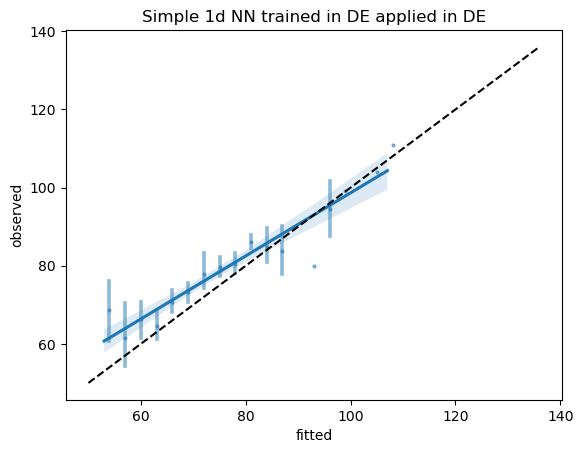

In [ ]:
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA)), 0, 1) #photoperiod_series_SSA, 
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved('Simple_NN_KG_SAT_pp', model, val_dl_SSA, method = 'regression', bce=True, CNN=False, title = 'Simple 1d NN trained in DE applied in DE')#